In [109]:
import sys
import logging

import numpy as np
import scipy as sp
import sklearn
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import mlp
import nalu

In [111]:
def create_data(min_val, max_val, n_elts, fun_op, fun_name, single_dim=False):
    if single_dim:
        if fun_name == 'sqrt':
            min_val = 0
        x = torch.randint(low=min_val, high=max_val + 1, size=(n_elts, 1)).float()
        y = fun_op(x).reshape(-1)
    else:
        x = torch.randint(low=min_val, high=max_val + 1, size=(n_elts, 2)).float()
        if fun_name == 'div':
            x = x[torch.nonzero(x[:, 1]).squeeze()]
        y = fun_op(x[:, 0], x[:, 1])

    return x, y


def split_data(data, less, greater, test_percentage=0.2):
    x, y = data
    inter = torch.nonzero(((x >= less) & (x <= greater)).all(dim=1))
    extra_less = torch.nonzero((x < less).any(dim=1))
    extra_greater = torch.nonzero((x > greater).any(dim=1))
    extra = torch.cat([extra_less, extra_greater], dim=0)
    x_extra = torch.index_select(x, 0, extra.squeeze())
    y_extra = torch.index_select(y, 0, extra.squeeze())
    x_inter = torch.index_select(x, 0, inter.squeeze())
    y_inter = torch.index_select(y, 0, inter.squeeze())
    cutoff = int((1.0 - test_percentage) * x_inter.shape[0])
    x_inter_train = x_inter[:cutoff]
    x_inter_test = x_inter[cutoff:]
    y_inter_train = y_inter[:cutoff]
    y_inter_test = y_inter[cutoff:]
    return (x_inter_train, y_inter_train), (x_inter_test, y_inter_test), (x_extra, y_extra)


def train(model, data, n_epochs, optimizer, lr, verbose=False):
    opt = optimizer(model.parameters(), lr=lr)
    x, y = data
    
    for epoch in range(n_epochs):
        pred = model(x).reshape(-1)
        mse = F.mse_loss(pred, y)
        mae = torch.mean(torch.abs(pred - y))
        
        opt.zero_grad()
        mse.backward()
        opt.step()
        
        if verbose and epoch % 10000 == 0:
            print(f'Epoch: {epoch}: mse={round(mse.item(), 2)}; mae={round(mae.item(), 2)}')
        
        
def test(model, data):
    x, y = data
    
    pred = model(x).reshape(-1)
    
    mse = F.mse_loss(pred, y)
    mae = torch.mean(torch.abs(pred - y))
    
    return round(mse.item(), 2), round(mae.item(), 2)

In [121]:
fun_dict = {
    'add': lambda x, y: x + y,
    'sub': lambda x, y: x - y,
    'mul': lambda x, y: x * y,
    'div': lambda x, y: x / y,
    'sqr': lambda x: torch.pow(x, 2),
    'sqrt': lambda x: torch.sqrt(x) 
}

models = {
    'tanh': nn.Tanh,
    'sigmoid': nn.Sigmoid,
    'relu6': nn.ReLU6,
    'softsign': nn.Softsign,
    'selu': nn.SELU,
    'elu': nn.ELU,
    'relu': nn.ReLU,
    'none': None,
    'NAC': None,
    'NALU': None,
    'SNALU': None,
}

In [122]:
N_LAYERS = 2
OUT_DIM = 1
HIDDEN_DIM = 2
N_EPOCHS = int(5e5)
OPTIMIZER = torch.optim.Adam
LR = 0.0005
DATA_RANGE = (-200, 200)
LESS_THAN = -100
GREATER_THAN = 100
N_ELTS = 1000

In [114]:
interpolation_logs = {}
extrapolation_logs = {}

for fun_name, fun_op in fun_dict.items():
    if fun_name in ['sqr', 'sqrt']:
        single_dim = True
        in_dim = 1
    else:
        single_dim = False
        in_dim = 2
        
    data = create_data(*DATA_RANGE, N_ELTS, fun_op, fun_name, single_dim)
    data_train, data_test, data_extra = split_data(data, less=LESS_THAN, greater=GREATER_THAN)

    interpolation_logs[fun_name] = {}
    extrapolation_logs[fun_name] = {}
    
    for model_name, act in models.items():
        if model_name == 'NAC':
            model = nalu.StackedNAC(N_LAYERS, in_dim, OUT_DIM, HIDDEN_DIM)
        elif model_name == 'NALU':
            model = nalu.StackedNALU(N_LAYERS, in_dim, OUT_DIM, HIDDEN_DIM)
        elif model_name == 'SNALU':
            model = nalu.StackedSNALU(N_LAYERS, in_dim, OUT_DIM, HIDDEN_DIM)
        else:
            model = mlp.MLP(N_LAYERS, in_dim, OUT_DIM, HIDDEN_DIM, act)

        train(model, data_train, N_EPOCHS, OPTIMIZER, LR)
        _, mae_inter = test(model, data_test)
        _, mae_extra = test(model, data_extra)

        interpolation_logs[fun_name][model_name] = mae_inter
        extrapolation_logs[fun_name][model_name] = mae_extra

        print(f'{fun_name.ljust(10)}: {model_name.ljust(10)}: mae inter: {mae_inter}, mae extra: {mae_extra}')
        
        del model

add       : tanh      : mae inter: 0.42, mae extra: 8.89
add       : sigmoid   : mae inter: 1.01, mae extra: 15.13
add       : relu6     : mae inter: 0.04, mae extra: 22.71
add       : softsign  : mae inter: 5.26, mae extra: 30.61
add       : selu      : mae inter: 0.14, mae extra: 9.51
add       : elu       : mae inter: 0.15, mae extra: 4.98
add       : relu      : mae inter: 0.02, mae extra: 10.44
add       : none      : mae inter: 0.0, mae extra: 0.0
add       : NAC       : mae inter: 0.0, mae extra: 0.0
add       : NALU      : mae inter: 94876.96, mae extra: 709.02
add       : SNALU     : mae inter: 0.0, mae extra: 0.0
sub       : tanh      : mae inter: 0.17, mae extra: 9.82
sub       : sigmoid   : mae inter: 2.8, mae extra: 42.25
sub       : relu6     : mae inter: 0.0, mae extra: 38.17
sub       : softsign  : mae inter: 4.69, mae extra: 40.69
sub       : selu      : mae inter: 0.02, mae extra: 14.02
sub       : elu       : mae inter: 0.01, mae extra: 0.01
sub       : relu      : m

## Just for debugging

In [128]:
data = create_data(*DATA_RANGE, N_ELTS, fun_dict['div'], 'div', single_dim=False)
data_train, data_test, data_extra = split_data(data, less=LESS_THAN, greater=GREATER_THAN)

In [132]:
model = nalu.StackedSNALU(N_LAYERS, in_dim=2, out_dim=OUT_DIM, hidden_dim=HIDDEN_DIM)

In [134]:
#train(model, data_train, N_EPOCHS, OPTIMIZER, lr=0.0005, verbose=True)
#print(test(model, data_test))
#print(test(model, data_extra))

## Plot results

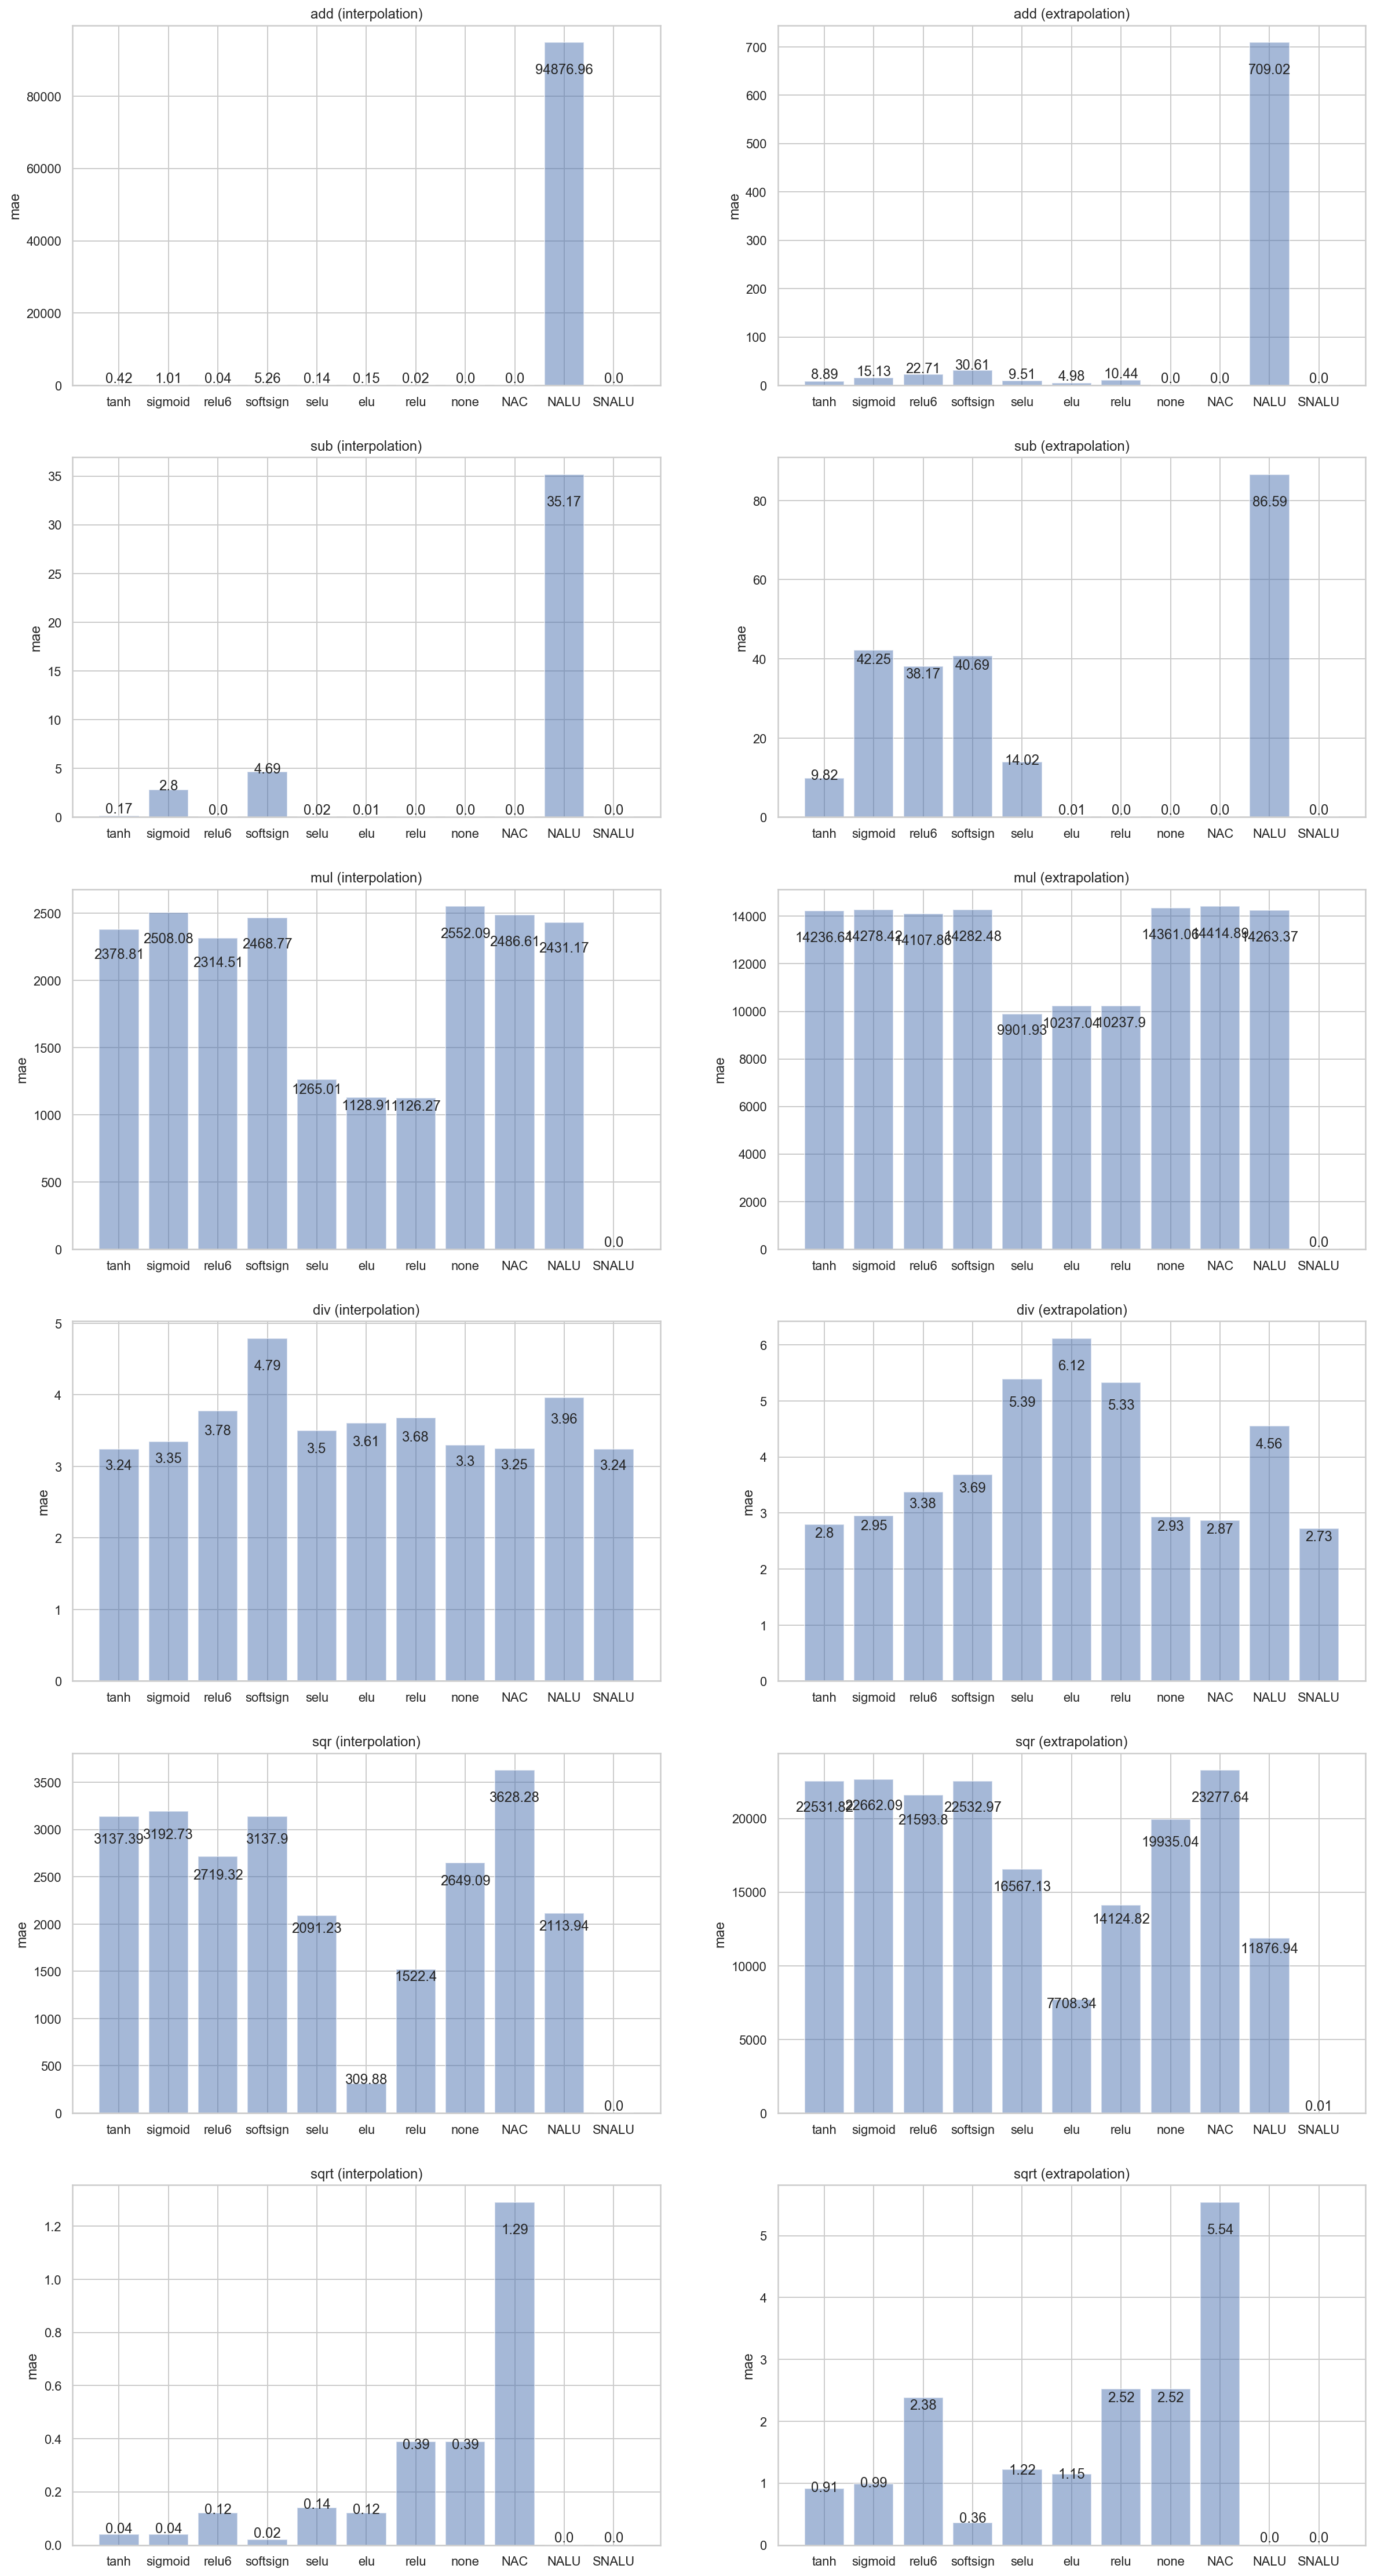

In [119]:
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., 0.9 * height,
                str(height), ha='center', va='bottom')

idx = 1
n_rows = len(interpolation_logs.keys())
figure = plt.figure(figsize=(20, 40))

for fun_name in interpolation_logs.keys():
    ax1 = figure.add_subplot(n_rows, 2, idx)

    items = list(interpolation_logs[fun_name].keys())
    y_pos = np.arange(len(items))
    mae = list(interpolation_logs[fun_name].values())

    rect1 = ax1.bar(y_pos, mae, align='center', alpha=0.5)
    ax1.set_xticks(np.arange(len(items)))
    ax1.set_xticklabels(items)
    ax1.set_ylabel('mae')
    ax1.set_title(f'{fun_name} (interpolation)')
    autolabel(rect1, ax1)

    ax2 = figure.add_subplot(n_rows, 2, idx + 1)

    items = list(extrapolation_logs[fun_name].keys())
    y_pos = np.arange(len(items))
    mae = list(extrapolation_logs[fun_name].values())

    rect2 = ax2.bar(y_pos, mae, align='center', alpha=0.5)
    ax2.set_xticks(np.arange(len(items)))
    ax2.set_xticklabels(items)
    ax2.set_ylabel('mae')
    ax2.set_title(f'{fun_name} (extrapolation)')
    autolabel(rect2, ax2)
    
    idx += 2

plt.show()